In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import ot
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import sklearn.neighbors
import torch
import tqdm

import celltrip

mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='darkgrid', palette='colorblind')


# Load Steady States

In [3]:
methods = ['Observed', 'CellTRIP', 'MLP', 'KNN']
# method_colors = {'Observed': 'gray', 'CellTRIP': 'cornflowerblue', 'MLP': 'limegreen', 'KNN': 'lightcoral'}
method_colors = {'Observed': 'gray'}
method_colors.update({method: c for method, c in zip(methods[1:], sns.color_palette('Purples_r', len(methods[1:])))})
development = np.array(['E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b'])
development_colors = {dev: c for dev, c in zip(development, sns.color_palette('Oranges', len(development)))}
# holdout_development = np.array(['E14-16h_a', 'L2_a'])
cell_types = np.array([
    'CNS', 'amnioserosa', 'carcass', 'epidermis', 'epidermis/CNS',
    'fat body', 'fat body/trachea', 'foregut', 'foregut/garland cells',
    'hemolymph', 'hindgut', 'hindgut/malpighian tubule', 'midgut',
    'midgut/malpighian tubules', 'muscle', 'salivary gland', 'testis',
    'trachea'])  # np.unique(np.concat([points['Observed'][dev]['meta']['annotation'].unique() for dev in development]))
cell_type_colors = {ct: c for ct, c in zip(cell_types, sns.color_palette('hls', len(cell_types)))}


In [4]:
points = {}
for method, dev in itertools.product(methods[1:], development):
    # Initialize
    if method not in points: points[method] = {}
    if dev not in points[method]: points[method][dev] = {}
    # Load imputed
    points[method][dev]['gex'] = None
    points[method][dev]['obs'] = np.load(f'../plots/flysta/{method}_{dev}.npy')
    if methods[0] in points and dev in points[methods[0]]:
        points[method][dev]['meta'] = points[methods[0]][dev]['meta']
    else: points[method][dev]['meta'] = pd.read_csv(f'../plots/flysta/meta_{dev}.csv', index_col=None)
    # Save observed
    if methods[0] not in points: points[methods[0]] = {}
    if dev not in points[methods[0]]:
        points[methods[0]][dev] = {}
        points[methods[0]][dev]['gex'] = None
        points[methods[0]][dev]['obs'] = np.load(f'../plots/flysta/spatial_{dev}.npy')
        points[methods[0]][dev]['meta'] = points[method][dev]['meta']


In [5]:
# Print validation
holdout_development = []
for dev in development:
    num_val = points['Observed'][dev]['meta']['Training']
    if num_val.all(): stage_class = 'Training'
    elif num_val.any(): stage_class = 'Mixed'
    else:
        stage_class = 'Validation'
        holdout_development.append(dev)
    print(f'{dev}: {stage_class}')


E14-16h_a: Training
E16-18h_a: Validation
L1_a: Training
L2_a: Training
L3_b: Training


# Legends

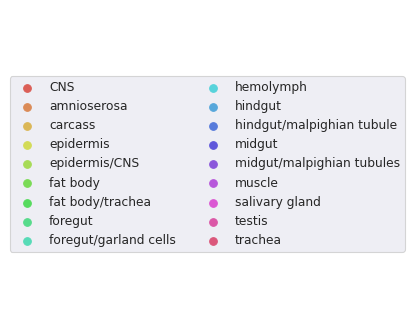

In [34]:
# Cell type legend
fig, ax = plt.subplots(figsize=(4, 4))
ax.legend(
    handles=[
        plt.scatter([], [], s=30, color=c, label=ct)
        for ct, c in cell_type_colors.items()
    ], ncols=2, loc='center')
ax.axis('off')
fig.savefig('../plots/flysta/cell_type_legend.pdf', transparent=True, bbox_inches='tight');

# Visualize

/home/ubuntu/miniconda3/envs/celltrip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


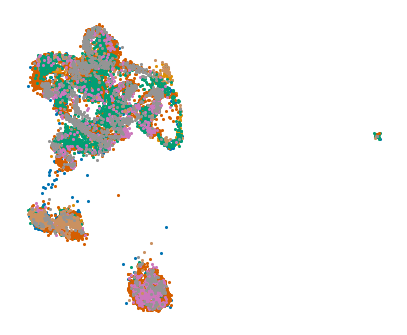

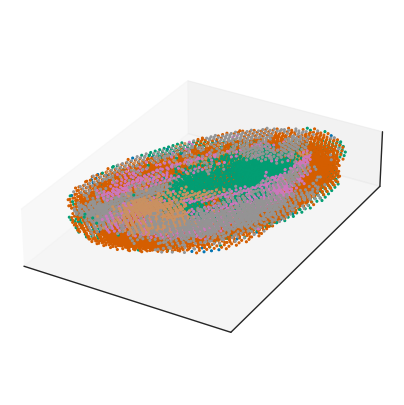

In [7]:
# Params
dev = 'E14-16h_a'

# Get GEX data
adata, = celltrip.utility.processing.read_adatas(f's3://nkalafut-celltrip/Flysta3D/{dev}_expression.h5ad')
import umap
X_umap = umap.UMAP(random_state=42).fit_transform(adata.X)

# Get gex logo
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data_types = points['Observed'][dev]['meta']['annotation']
for ct in cell_types:
    data_filt = X_umap[(data_types==ct).to_numpy()]
    ax.scatter(*data_filt.T, label=ct, s=2., alpha=1.)
ax.grid(False)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[])
sns.despine(ax=ax, left=True, bottom=True)
fig.savefig('../plots/flysta/stage_gex_visualization.pdf', transparent=True, bbox_inches='tight');

# Get spatial logo
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(5, 5))
data = points['Observed'][dev]['obs']
# mask = data[:, -1]<5
# mask *= np.random.rand(mask.shape[0]) < .5
# data = data[:, [1, 2, 0]]  # [mask]
data_types = points['Observed'][dev]['meta']['annotation']
for ct in cell_types:
    data_filt = data[data_types==ct]
    ax.scatter(*data_filt.T, label=ct, s=2., alpha=1.)
ax.grid(False)
ax.set_aspect('equal')
ax.set(xticks=[], yticks=[], zticks=[])
fig.savefig('../plots/flysta/stage_spatial_visualization.pdf', transparent=True, bbox_inches='tight');


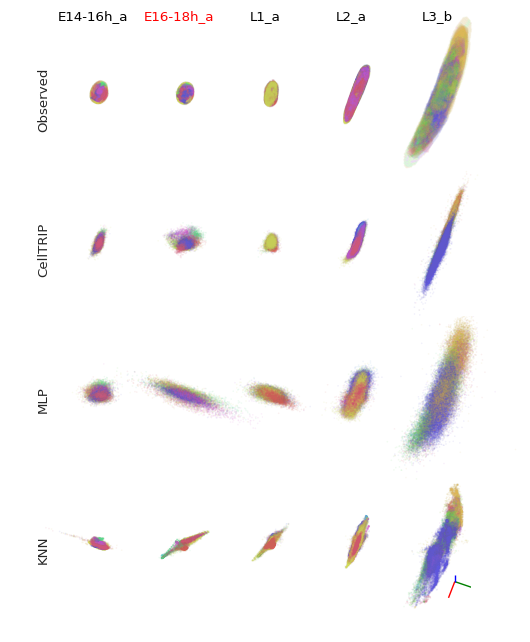

In [8]:
# Create figure
fig, axs = plt.subplots(len(methods), len(development), subplot_kw={'projection': '3d'}, figsize=(2*len(development), 2*len(methods)))

# Data
camera_kwargs = {'elev': 70, 'azim': 20}
pca_class = {dev: sklearn.decomposition.PCA().fit(points['Observed'][dev]['obs']) for dev in development}
for ax, (method, dev) in zip(axs.flatten(), itertools.product(methods, development)):
    # Share axes
    reference = 0  # All same scale
    # reference = np.argwhere(np.array(development)==dev)[0, 0]  # Development same scale
    if ax != axs.flatten()[reference]:
        ax.sharex(axs.flatten()[reference])
        ax.sharey(axs.flatten()[reference])
        ax.sharez(axs.flatten()[reference])

    # Get data
    data = points[method][dev]['obs']
    data_types = points['Observed'][dev]['meta']['annotation']
    # sub_idx = np.random.choice(data.shape[0], 5_000, replace=False)  # Subsample for speed, only for testing
    # data = data[sub_idx]  # TESTING
    # data_types = data_types.iloc[sub_idx]  # TESTING
    data = celltrip.utility.general.transform_and_center(data, pca_class[dev])
    for ct in cell_types:
        # Plot
        data_filt = data[data_types==ct]
        # data_filt = data_filt[np.abs(data_filt[:, 2] - 0) < .5]  # Z-filtering
        ax.scatter(*data_filt.T, color=cell_type_colors[ct], alpha=.1, label=ct, s=.1)
        ax.set_aspect('equal')

        # Adjust axes
        for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
            # Adjust ticker
            axis.set_major_locator(mpl.ticker.MultipleLocator(base=10.))
            # Remove labels
            axis.set_ticklabels([])
            # Remove small tick lines
            axis._axinfo['tick']['inward_factor'] = 0.
            axis._axinfo['tick']['outward_factor'] = 0.
            # Remove all faces and ticks
            axis.set_ticks([])
            axis.set_pane_color((1., 1., 1., 0.))
            axis.line.set_color((1., 1., 1., 0.))
        
        # Camera location
        ax.view_init(**camera_kwargs)  # YX Plane, slightly offset
        # Transparent background
        ax.set_facecolor('none')

# Super labels
for ax, method in zip(axs[:, 0], methods): ax.text2D(.2, .5, method, rotation=90, ha='center', va='center', fontsize='medium', transform=ax.transAxes)
for ax, dev in zip(axs[0], development):
    ax.text2D(.5, 1., dev, rotation=0, ha='center', va='center', color='red' if dev in holdout_development else 'black', fontsize='medium', transform=ax.transAxes)

# Orientation indicator
# ax = axs[0][0].inset_axes((.2, .75, .2, .2), projection='3d')
ax = axs[-1][-1].inset_axes((.5, .2, .2, .2), projection='3d')
ax.set_facecolor('none')
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Remove labels
    axis.set_ticklabels([])
    # Remove small tick lines
    axis._axinfo['tick']['inward_factor'] = 0.
    axis._axinfo['tick']['outward_factor'] = 0.
    # Remove all faces and ticks
    axis.set_ticks([])
    axis.set_pane_color((1., 1., 1., 0.))
    axis.line.set_color((1., 1., 1., 0.))
ax.grid(False)
ax.quiver(0, 0, 0, 1, 0, 0, length=.1, arrow_length_ratio=0., lw=1., color='red', zorder=1)
ax.quiver(0, 0, 0, 0, 1, 0, length=.1, arrow_length_ratio=0., lw=1., color='green', zorder=1)
ax.quiver(0, 0, 0, 0, 0, 1, length=.1, arrow_length_ratio=0., lw=1., color='blue', zorder=1)
ax.view_init(**camera_kwargs)
ax.set_aspect('equal')

# Closer together
fig.subplots_adjust(wspace=-.8, hspace=-.1)
# fig.show()
fig.savefig('../plots/flysta/prediction_visualizations.pdf', transparent=True, bbox_inches='tight')


# Performance

In [9]:
# Clustering performance
classification_performance = []
for dev in development:
    # Train classifier
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=200)
    y_true = points['Observed'][dev]['meta']['annotation'].to_numpy()
    knn.fit(points['Observed'][dev]['obs'], y_true)
    for method in methods:
        # Predict on imputed data
        if method == 'Observed': continue
        pred = knn.predict(points[method][dev]['obs'])
        for ct in cell_types.tolist()+['All']:
            if ct == 'All': subset_idx = slice(None)
            else:
                subset_idx = np.argwhere(y_true==ct).flatten()
                if len(subset_idx) == 0: continue
            knn_acc = (y_true[subset_idx] == pred[subset_idx]).mean()
            mse = np.square(points['Observed'][dev]['obs'][subset_idx] - points[method][dev]['obs'][subset_idx]).mean()
            classification_performance.append({
                'Method': method, 'Development': dev, 'Cell Type': ct, 'KNN Accuracy': knn_acc, 'MSE': mse})
classification_performance = pd.DataFrame(classification_performance)
# classification_performance.loc[classification_performance['Development']=='E16-18h_a', ['Method', 'Cell Type', 'MSE', 'KNN Accuracy']].groupby(['Cell Type', 'Method']).first()


/tmp/ipykernel_5402/3007551916.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])


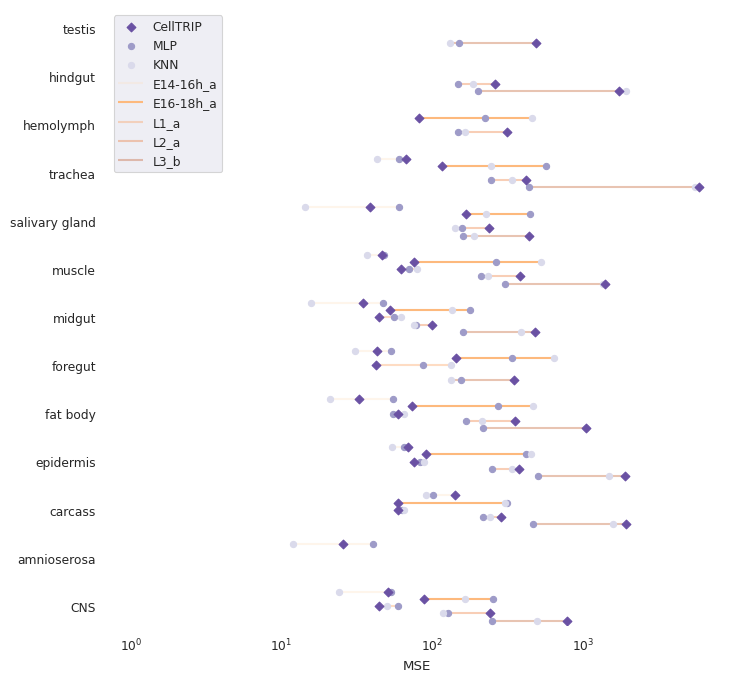

In [33]:
# Params
# statistic = 'KNN Accuracy'
# xlog = False
statistic = 'MSE'
xlog = True

# Plot
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
if xlog: ax.set_xscale('log')

# Prepare data
df = classification_performance.copy()
df = df.loc[df['Cell Type'].apply(lambda s: '/' not in s)]  # NOTE: Just drops these, but doesn't in the 'All' calculation
# df = df.loc[df['Development'].isin(holdout_development)]  # Only show holdouts
df_all = df.loc[df['Cell Type']=='All']
df_specific = df.loc[df['Cell Type']!='All']

# Set ticks
yticklabels = df_specific['Cell Type'].unique()
ax.set(
    yticks=range(len(yticklabels)),
    yticklabels=yticklabels)

# Set comparison point
midpoint = 1. / len(yticklabels)  # df_all['Accuracy'].mean()

# Apply offsets
offset = .3
development_offsets = -np.linspace(-offset, offset, len(df_specific['Development'].unique()))
df_specific['y'] = df_specific['Cell Type'].apply(lambda s: {l: float(i) for i, l in enumerate(yticklabels)}[s])
for i, dev in enumerate(df_specific['Development'].unique()):
    # Offset
    df_specific.loc[df_specific['Development']==dev, 'y'] += development_offsets[i]
    
# Plot by method
for method in methods:
    if method == 'Observed': continue
    df_filt = df_specific.loc[df_specific['Method']==method]
    ax.scatter(
        df_filt[statistic], df_filt['y'],
        color=method_colors[method], marker='D' if method == 'CellTRIP' else 'o',
        s=20., label=method, zorder=10 if method=='CellTRIP' else 2)

# Draw lines
df_group = df_specific.groupby(['Cell Type', 'Development']).agg({'y': 'first', statistic: ['min', 'max']}).reset_index()
if not xlog: ax.axvline(x=midpoint, color='gray', alpha=.4, zorder=.9)
for dev in df_specific['Development'].unique():
    df_filt = df_group.loc[df_group['Development']==dev]
    ax.hlines(
        df_filt['y']['first'],
        df_filt[statistic]['min'],
        df_filt[statistic]['max'],
        # np.minimum(midpoint, df_filt[statistic]['min']),
        # np.maximum(midpoint, df_filt[statistic]['max']),
        color=development_colors[dev], alpha=1. if dev in holdout_development else .3, lw=1.5, label=dev, zorder=.8)

# Format
ax.set_xlabel(statistic)
ax.set_ylim(-offset-.1, len(yticklabels)-1+offset+.1)
sns.despine(ax=ax, left=True, bottom=True)
ax.legend()
fig.savefig('../plots/flysta/prediction_classification_performance_lines.pdf', transparent=True, bbox_inches='tight')


/tmp/ipykernel_5402/1603184543.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), ha='center', x=-.31)


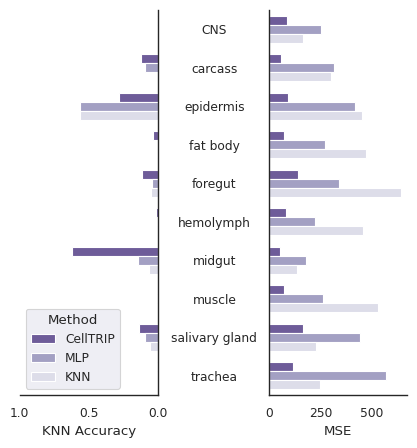

In [11]:
# Figure creation
with sns.axes_style('white'):
    fig, axs = plt.subplots(1, 2, figsize=(5, 5), gridspec_kw={'wspace': .8})
    axs = axs[::-1]

# Data preparation
df = classification_performance.copy()
df = df.loc[df['Cell Type'].apply(lambda s: '/' not in s)]
df = df.loc[df['Cell Type']!='All']
df = df.loc[df['Development'].isin(holdout_development)]
# df['-log10(MSE)'] = -np.log10(df['MSE'])

# Left
sns.barplot(df, x='MSE', y='Cell Type', hue='Method', palette=method_colors, width=.7, legend=False, ax=axs[0])
# axs[0].set_yticks([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), ha='center', x=-.31)
# axs[0].invert_xaxis()
# sns.despine(ax=axs[0], left=True, right=False)
sns.despine(ax=axs[0])

# Right
sns.barplot(df, x='KNN Accuracy', y='Cell Type', hue='Method', palette=method_colors, width=.7, ax=axs[1])
axs[1].set_yticks([])
axs[1].set_xlim(0, 1)
axs[1].set_yticklabels(axs[1].get_yticklabels(), ha='center', x=-.31)
axs[1].invert_xaxis()
# sns.despine(ax=axs[1])
sns.despine(ax=axs[1], left=True, right=False)
# ax.axvline(x=midpoint, color='gray', alpha=.4, zorder=.9)

# Common
for ax in axs: ax.set_ylabel(None)
fig.savefig('../plots/flysta/prediction_classification_performance_butterfly.pdf', transparent=True, bbox_inches='tight')


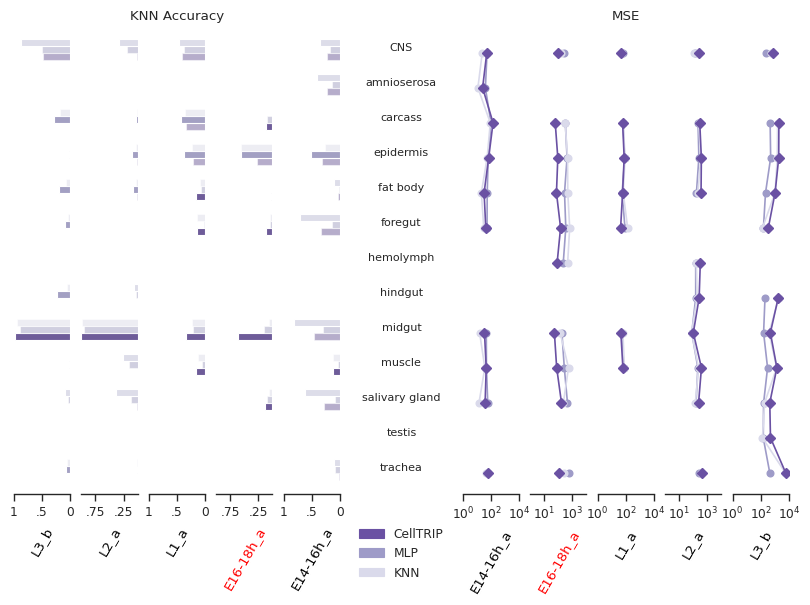

In [12]:
# Params
stat_left, stat_right = 'MSE', 'KNN Accuracy'

# Plot
with sns.axes_style('white', {'axes.linewidth': 0.5, 'xtick.bottom': True}):
    fig = plt.figure(figsize=(10, 6))
    gs_outer = mpl.gridspec.GridSpec(1, 3, width_ratios=[len(development), 1.5, len(development)], wspace=.05)
    gs_left = mpl.gridspec.GridSpecFromSubplotSpec(1, len(development), subplot_spec=gs_outer[0])
    gs_center, = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_outer[1])
    gs_right = mpl.gridspec.GridSpecFromSubplotSpec(1, len(development), subplot_spec=gs_outer[2])
    axs_left = [fig.add_subplot(cell) for cell in gs_left][::-1]
    ax_center = fig.add_subplot(gs_center)
    axs_right = [fig.add_subplot(cell) for cell in gs_right]
    axs = axs_left + axs_right
# axs_left = axs[len(development)-1::-1]
# axs_right = axs[len(development):]

# Mirror
axs_left, axs_right = axs_right, axs_left

# Prepare data
df = classification_performance.copy()
df = df.loc[df['Cell Type'].apply(lambda s: '/' not in s)]  # NOTE: Just drops these, but doesn't in the 'All' calculation
df = df.loc[df['Cell Type']!='All']
# Add NAN values
for method, dev, ct in itertools.product(df['Method'].unique(), df['Development'].unique(), df['Cell Type'].unique()):
    df_filt = df
    df_filt = df_filt.loc[df_filt['Method']==method]
    df_filt = df_filt.loc[df_filt['Development']==dev]
    df_filt = df_filt.loc[df_filt['Cell Type']==ct]
    if len(df_filt) == 0:
        df = pd.concat([df, pd.DataFrame({'Method': method, 'Development': dev, 'Cell Type': ct}, index=[0])])
df = df.sort_values('Cell Type', ascending=False)

# MSE Axes
for i, (ax, dev) in enumerate(zip(axs_left, development)):
    for method in methods:
        df_filt = df
        df_filt = df_filt.loc[df_filt['Development']==dev]
        df_filt = df_filt.loc[df_filt['Method']==method]
        ax.plot(
            df_filt[stat_left], df_filt['Cell Type'],
            color=method_colors[method], marker='D' if method == 'CellTRIP' else 'o',
            label=method, zorder=10 if method=='CellTRIP' else 2)
    ax.set_xscale('log')
    if (i % 2) == 0: ax.set(xticks=[1, 100, 10_000], xticklabels=['$10^0$', '$10^2$', '$10^4$'])
    else: ax.set(xticks=[10, 1_000], xticklabels=['$10^1$', '$10^3$'])
    ax.set_xlim(1, 10_000)
    # ax.invert_xaxis()
    xlabel_color = 'red' if dev in holdout_development else 'black'
    ax.set_xlabel(dev, color=xlabel_color, rotation=60)

# KNN Axes
for i, (ax, dev) in enumerate(zip(axs_right, development)):
    df_filt = df.loc[df['Development']==dev].fillna(0)  # FillNA for patches
    sns.barplot(
        df_filt, x=stat_right, y='Cell Type',
        hue='Method', hue_order=method_colors.keys(), palette=method_colors,
        width=.8, legend=False, ax=ax)
    if (i % 2) == 0: ax.set(xticks=[0., .5, 1.], xticklabels=['0', '.5', '1'])
    else: ax.set(xticks=[.25, .75], xticklabels=['.25', '.75'])
    ax.set_xlim(0, 1)
    ax.set_ylabel(None)
    ax.invert_yaxis()
    ax.invert_xaxis()
    xlabel_color = 'red' if dev in holdout_development else 'black'
    ax.set_xlabel(dev, color=xlabel_color, rotation=60)

    # Apply alpha to non-best bars
    num_cell_types = df['Cell Type'].unique().shape[0]
    for i in range(0, num_cell_types):
        # Get widths
        patches = ax.patches[i::num_cell_types]
        widths = [p.get_width() for p in patches]
        best_idx = np.argmax(widths)
        # Alpha all others
        for i, p in enumerate(patches):
            if i == best_idx: continue
            p.set_alpha(.5)

# Common formatting
ylims = (min([ax.get_ylim()[0] for ax in axs]), max([ax.get_ylim()[1] for ax in axs]))
for ax in axs:
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(ylims)
    sns.despine(ax=ax, left=True)

# Labels
ax_center.set_axis_off()
trans = mpl.transforms.blended_transform_factory(ax_center.transAxes, axs_left[0].transData)
for i, ct in enumerate(df['Cell Type'].unique()):
    ax_center.text(.5, i, ct, ha='center', va='bottom', fontsize='small', transform=trans)
is_even = (len(development) % 2) == 0
ax_center.text(
    .5 if not is_even else 1.05, 1.02, stat_left,
    ha='center', va='bottom', fontsize='medium',
    transform=axs_left[((len(development)+1)//2)-1].transAxes)
ax_center.text(
    .5 if not is_even else 1.05, 1.02, stat_right,
    ha='center', va='bottom', fontsize='medium',
    transform=axs_right[((len(development)+1)//2)-1].transAxes)

# Legend
ax_center.legend(handles=[
    mpl.patches.Patch(color=c, label=m)
    for m, c in method_colors.items() if m != 'Observed'],
    frameon=False, bbox_to_anchor=(.5, -.05), loc='upper center')

# Save
fig.savefig('../plots/flysta/prediction_classification_performance_combined.pdf', transparent=True, bbox_inches='tight')


# Interpolation

In [ ]:
# Load transition data
idx = np.argwhere(development==holdout_development[-1])[0, 0]
sequence_dev = development[idx-1:idx+2]
transition = np.load(f'../plots/flysta/Interpolated_CellTRIP_{sequence_dev[1]}.npy')
data = transition[[0, 4, -1]]  # Takes first, last, and 200

# Orient the data
_, pca = celltrip.utility.general.transform_and_center(transition[-1], return_pca=True)
data = pca.transform(data.reshape((-1, data.shape[-1]))).reshape(data.shape)

# Compute EMD
interp_loss = {}
interp_loss['CellTRIP'] = celltrip.utility.distance.compute_emd(
    celltrip.utility.general.transform_and_center(points['Observed'][sequence_dev[1]]['obs']),
    celltrip.utility.general.transform_and_center(data[1]))
for progress in (.25, .5, .75):
    method = f'LERP-{progress:.2f}'
    interp_loss[method] = celltrip.utility.distance.compute_emd(
        celltrip.utility.general.transform_and_center(
            np.load(f'../plots/flysta/Interpolated_{method}_{sequence_dev[1]}.npy')),
        celltrip.utility.general.transform_and_center(data[1]))

# Infer types (TODO: Revise this or justify, this seems like cheating)
types = []
_, types_pca = celltrip.utility.general.transform_and_center(points['Observed'][sequence_dev[-1]]['obs'], return_pca=True)
for i, dev in enumerate(sequence_dev):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10).fit(types_pca.transform(points['Observed'][dev]['obs']), points['Observed'][dev]['meta']['annotation'])
    types.append(knn.predict(data[i]))

# Offset the data
spread = 50
data_offsets = -np.linspace(-spread, spread, data.shape[0])  # Offset earlier development higher
data[..., -1] += data_offsets.reshape((data.shape[0], 1))


/tmp/ipykernel_5402/3731226575.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_ticklabels([f'{tl.get_text()} mm' for tl in axis.get_ticklabels()])  # Add units
/tmp/ipykernel_5402/3731226575.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_ticklabels([f'{tl.get_text()} mm' for tl in axis.get_ticklabels()])  # Add units
/tmp/ipykernel_5402/3731226575.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_ticklabels([f'{tl.get_text()} mm' for tl in axis.get_ticklabels()])  # Add units


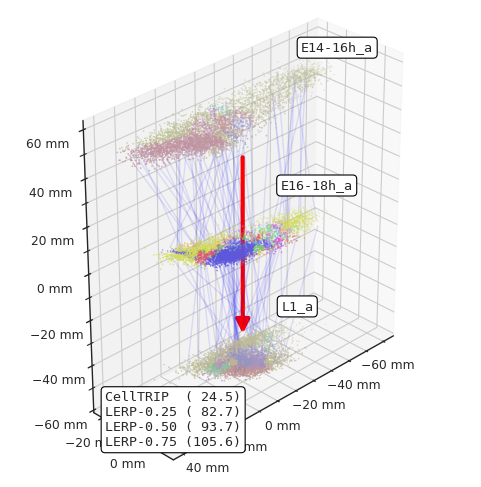

In [14]:
# Arrow3D (https://stackoverflow.com/a/22867877)
class Arrow3D(mpl.patches.FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = mpl_toolkits.mplot3d.proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

# Plot
fig = plt.figure(figsize=(6, 6))
with sns.axes_style('white'):
    ax = fig.add_subplot(111, projection='3d')
# Main plot
for ct, (i, dev) in itertools.product(cell_types, enumerate(sequence_dev)):
    color = np.array(cell_type_colors[ct])
    if dev != sequence_dev[1]:
        color = (1/3)*color + (2/3)*np.array(3*[.7])
    ax.scatter(
        *data[i][types[i]==ct].T,
        color=color,
        # alpha=.5 if dev != intermediate_dev else 1.,
        s=.1, label=ct)
# Development quivers
arrow = Arrow3D(
    (0, 0), (0, 0), (.8*data[:, -1].max(), .8*data[:, -1].min()),
    lw=3, mutation_scale=20, arrowstyle='-|>', color='red')
ax.add_artist(arrow)
# OT lines
num_lines = 50
for i in range(len(sequence_dev)-1):
    pairs = np.random.choice(data.shape[1], num_lines, replace=False)
    pair_coords = np.stack([data[i, pairs], data[i+1, pairs]], axis=1)
    for coords in pair_coords:
        ax.plot(*coords.T, lw=1., alpha=.1, color='blue')
# Modify ticks
for i, axis in enumerate((ax.xaxis, ax.yaxis, ax.zaxis)):
    # Adjust ticker
    axis.set_major_locator(mpl.ticker.MultipleLocator(base=20.))
    axis.set_minor_locator(mpl.ticker.MultipleLocator(base=10.))
    # axis.set_ticks(axis.get_ticklocs())
    axis.set_ticklabels([f'{tl.get_text()} mm' for tl in axis.get_ticklabels()])  # Add units
    # Rotations and pad
    if i == 0: axis.set_tick_params(rotation=0, pad=2)
    elif i == 1: axis.set_tick_params(rotation=0, pad=0)
    elif i == 2: axis.set_tick_params(rotation=0, pad=10)
    # Only x-axis
    # if i != 0:
    #     # Remove labels
    #     axis.set_ticklabels([])
    #     # Remove small tick lines
    #     axis._axinfo['tick']['inward_factor'] = 0.
    #     axis._axinfo['tick']['outward_factor'] = 0.
    # else:
    #     axis.set_ticklabels([f'{tl.get_text()} mm' for tl in axis.get_ticklabels()])  # Add units

# Annotations
ax.text3D(
    -50, 0, data_offsets[0]+15, sequence_dev[0], ha='center', va='center', fontfamily='monospace',
    fontsize='medium', bbox=dict(
        facecolor='white', boxstyle='round', edgecolor='black'), zorder=100)
ax.text3D(
    -40, 0, data_offsets[1]+10, sequence_dev[1], ha='center', va='center', fontfamily='monospace',
    fontsize='medium', bbox=dict(
        facecolor='white', boxstyle='round', edgecolor='black'), zorder=100)
ax.text3D(
    -30, 0, data_offsets[2]+10, sequence_dev[-1], ha='center', va='center', fontfamily='monospace',
    fontsize='medium', bbox=dict(
        facecolor='white', boxstyle='round', edgecolor='black'), zorder=100)
ax.text3D(
    # ax.get_xlim()[1]-2, ax.get_ylim()[0]+2, ax.get_zlim()[1]+40,
    # ax.get_xlim()[1]+20, ax.get_ylim()[0]+2, ax.get_zlim()[0]+20,
    ax.get_xlim()[1], ax.get_ylim()[1], ax.get_zlim()[0]+5,
    '\n'.join([
        f'{method}'.ljust(1+max(map(len, interp_loss.keys())))
        + f'({loss: >5.1f})' for method, loss in interp_loss.items()]),
    ha='center', va='bottom', fontfamily='monospace', fontsize='medium', bbox=dict(
        facecolor='white', edgecolor='black', alpha=1., boxstyle='round'), zorder=100)
# Formatting
# ax.set(xlabel='x', ylabel='y', zlabel='z')
ax.view_init(elev=30, azim=45)
ax.set_aspect('equal')

# Ticks

# fig.show()
fig.savefig('../plots/flysta/interpolation_visualization.pdf', transparent=True, bbox_inches='tight')


# Knockdown

In [ ]:
# Load knockdown data
# TODO: Determine significance
knockdown_results = pd.read_csv('../plots/flysta/knockdown.csv', index_col=None)
# knockdown_results = pd.read_csv('../plots/flysta/knockdown_most_recent_old.csv', index_col=None)  # Used in paper, used 1x time scale
# knockdown_results = pd.read_csv('../plots/flysta/knockdown_pre_.5.csv', index_col=None)

# Adjust by ct and dev knockdown base
# NOTE: Adjusts significance calculation, ideally wouldn't be needed
stat_cols = ['Effect Size', 'Trajectory Length']
dev_base_mean = knockdown_results.groupby(['Development', 'Cell Type'])[stat_cols].mean()  # Means
dev_base_std = knockdown_results.groupby(['Development', 'Cell Type'])[stat_cols].std()  # STDs
# dev_base_std = knockdown_results.groupby(['Development', 'Development'])[stat_cols].std()  # STDs
# Control
# dev_base = knockdown_results.loc[knockdown_results['Gene']=='Control'].set_index(['Development', 'Cell Type'])[stat_cols]
# knockdown_results[stat_cols] = (
#     knockdown_results[stat_cols]
#     - dev_base_mean.loc[
#         list(
#             knockdown_results[['Development', 'Cell Type']]
#                 .itertuples(name=None, index=False))].reset_index(drop=True))
# Subtract mean
knockdown_results[stat_cols] = (
    knockdown_results[stat_cols]
    - dev_base_mean.loc[
        list(
            knockdown_results[['Development', 'Cell Type']]
                .itertuples(name=None, index=False))].reset_index(drop=True))
# Scale by std
knockdown_results[stat_cols] = (
    knockdown_results[stat_cols]
    / dev_base_std.loc[
        list(
            knockdown_results[['Development', 'Cell Type']]  # [['Development', 'Development']]
                .itertuples(name=None, index=False))].reset_index(drop=True))
# Remove control
knockdown_results = knockdown_results.loc[knockdown_results['Gene'] != 'Control']

# Compute correlations
knockdown_significance = []
iterables = [knockdown_results[col].unique() for col in ('Gene', 'Cell Type')]
for gene, ct in tqdm.tqdm(itertools.product(*iterables), mininterval=1., total=np.prod([len(itb) for itb in iterables])):
    # Pull data
    df_filt = knockdown_results.loc[(knockdown_results['Gene']==gene)*(knockdown_results['Cell Type']==ct)]
    x = df_filt['Development'].apply(lambda s: {l: float(i) for i, l in enumerate(development)}[s])
    # Calculate statistics
    result = {'Gene': gene, 'Cell Type': ct}
    for stat in stat_cols:
        # Get data and initialize
        y = df_filt[stat]
        cant_fit = (np.std(x)==0) or (np.std(y)==0) or (len(x) < 3)
        # Distribution
        result[f'{stat} Mean'] = y.mean()
        result[f'{stat} STD'] = y.std()
        # Polyfit
        if not cant_fit: m, b = np.polyfit(x, y, 1)
        else: m = 0.
        result[f'{stat} Polyfit Slope'] = m
        # Pearson
        if not cant_fit:
            res = scipy.stats.pearsonr(x, y)
            corr, sig = res.statistic, res.pvalue
        else: corr, sig = 0., 1.
        result[f'{stat} Pearson Correlation'] = corr
        result[f'{stat} Pearson Significance'] = sig
        # Spearman
        if not cant_fit:
            res = scipy.stats.spearmanr(x, y)
            corr, sig = res.statistic, res.pvalue
        else: corr, sig = 0., 1.
        result[f'{stat} Spearman Correlation'] = corr
        result[f'{stat} Spearman Significance'] = sig
    # Record
    knockdown_significance.append(result)
knockdown_significance = pd.DataFrame(knockdown_significance).set_index(['Gene', 'Cell Type'])


100%|██████████| 19000/19000 [02:53<00:00, 109.62it/s]


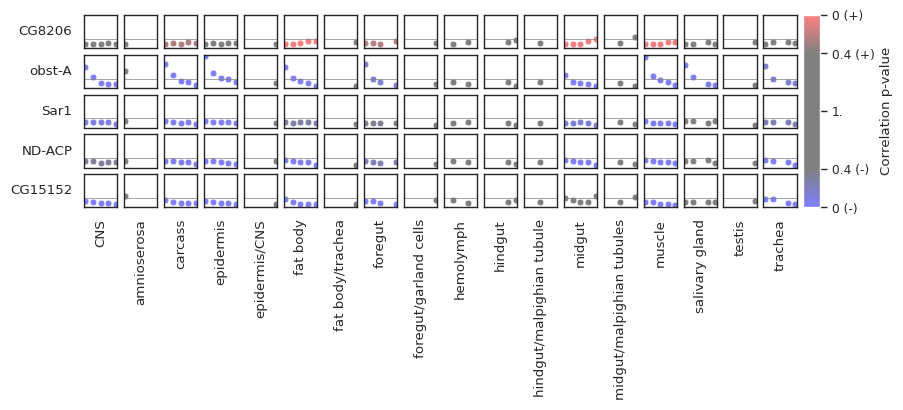

In [7]:
# Parameters
bar_statistic = 'Effect Size'
# bar_statistic = 'Trajectory Length'
corr_statistic, sig_statistic = f'{bar_statistic} Pearson Correlation', f'{bar_statistic} Pearson Significance'
num_genes = 5
# cell_types_to_use = ['CNS', 'midgut', 'muscle', 'trachea']
cell_types_to_use = cell_types

# Select genes
genes = []
# Manually
# genes += ['Ubx', 'Abd-B', 'Dfd']
# Select best for each CT
# std_col = f'{bar_statistic} STD'
# rank_ordered = (
#     knockdown_significance[[sig_statistic, std_col]]
#         .sort_values([sig_statistic, std_col], ascending=[True, False])
#         .reset_index())
# for ct in cell_types_to_use:
#     df = rank_ordered.loc[rank_ordered['Cell Type'] == ct]
#     genes.append(df['Gene'].iloc[0])
# Randomly fill others
np.random.seed(42)
df_filt = knockdown_significance.loc[knockdown_significance.index.get_level_values('Cell Type').isin(cell_types_to_use)]
mag = df_filt[f'{bar_statistic} Mean'].abs().groupby('Gene').mean()
std = df_filt[f'{bar_statistic} STD'].groupby('Gene').max()
sig = df_filt[sig_statistic].groupby('Gene').min()
p = (df_filt[sig_statistic] < .05).groupby('Gene').sum()
p /= p.sum()
genes += np.random.choice(p.index, num_genes-len(genes), p=p).tolist()  # Random weighted

# Create figure
fig = plt.figure(figsize=(.5*len(cell_types_to_use)+.5, .5*num_genes))
with sns.axes_style('white'):
    axs = fig.subplots(num_genes, len(cell_types_to_use)+1, width_ratios=len(cell_types_to_use)*[1]+[.5], sharex=True, sharey=True)
gs = axs[0, 0].get_gridspec()
for ax in axs[:, -1]: ax.remove()
cbar_ax = fig.add_subplot(gs[:, -1])

# Create CMAP
# TODO: Maybe center all around 0/make min 0, color intensity by magnitude
color_start = .4
mid_color = (.5, .5, .5)
pos_color = (1., .5, .5)
neg_color = (.5, .5, 1.)
cdict = {
    clr_str: [
        [0., neg_color[i], neg_color[i]],
        [color_start/2, mid_color[i], mid_color[i]],
        [1.-color_start/2, mid_color[i], mid_color[i]],
        [1., pos_color[i], pos_color[i]]]
    for i, clr_str in enumerate(('red', 'green', 'blue'))}
cmap = mpl.colors.LinearSegmentedColormap('sig', segmentdata=cdict)
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Select and plot genes
for i, (axs_gene, gene) in enumerate(zip(axs, genes)):
    for j, (ax, ct) in enumerate(zip(axs_gene, cell_types_to_use)):
        # Filter data
        df_filt = knockdown_results.loc[(knockdown_results['Gene']==gene)*(knockdown_results['Cell Type']==ct)]

        # Identify trend
        corr, sig = knockdown_significance.loc[(gene, ct), [corr_statistic, sig_statistic]]
        # CMAP color
        eff_sig = -np.sign(corr) * sig + (1 + np.sign(corr))  # Goes to 2 if pos sig corr, 0 otherwise
        color = cmap(norm(eff_sig))

        # Barplot
        # sns.barplot(df_filt, x='Development', y=bar_statistic, errorbar=None, color=color, edgecolor=None, ax=ax)
        sns.scatterplot(df_filt, x='Development', y=bar_statistic, color=color, markers=True, ax=ax)

        # Style
        ax.set_xlabel(ct, rotation=90, labelpad=0, ha='center', va='top')
        ax.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
        # ax.set_aspect('equal', 'box')
        ax.axhline(0, color='gray', lw=.5)
        if i == len(genes)-1: ax.set_xlabel(ct, rotation=90, labelpad=0, ha='center', va='top')
        if j == 0: ax.set_ylabel(gene, rotation=0, labelpad=0, ha='right', va='center')

# Extend lims
low, high = ax.get_ylim()
ax.set_ylim(bottom=min(0, low), top=max(0, high))  # Ensure 0 somewhere
# maxabslim = np.max([-knockdown_results[bar_statistic].min(), knockdown_results[bar_statistic].max()])  # Absolute maxabs
# maxabslim = max(np.abs(np.array(ax.get_ylim())))  # Shown maxabs
# Equal lims
# ax.set_ylim(-maxabslim, maxabslim)

# Colorbar
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical', label='Correlation p-value')
cbar_ax.set(
    yticks=[0., color_start, 1., 2-color_start, 2.],
    yticklabels=['0 (-)', f'{color_start} (-)', '1.', f'{color_start} (+)', '0 (+)'])

# Save
fig.savefig('../plots/flysta/perturbation_effects_bars.pdf', transparent=True, bbox_inches='tight')


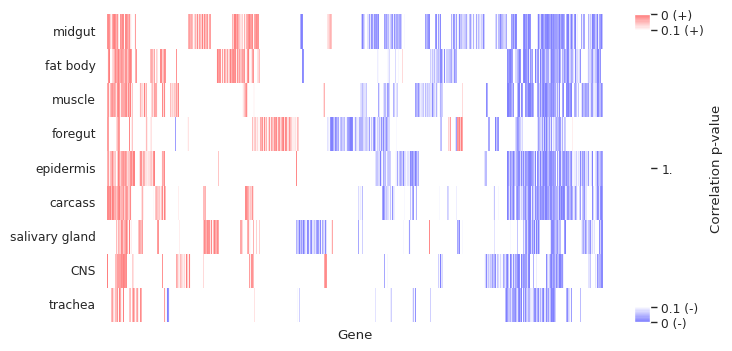

In [8]:
# Parameters
bar_statistic = 'Effect Size'
# bar_statistic = 'Trajectory Length'
corr_statistic, sig_statistic = f'{bar_statistic} Pearson Correlation', f'{bar_statistic} Pearson Significance'
genes_to_annotate = ['rpr', 'MFS15']
color_start = .1

# Format data
df_filt = knockdown_significance.loc[knockdown_significance.index.get_level_values('Cell Type') != 'All']
df_sig = df_filt.reset_index().pivot(index='Cell Type', columns='Gene', values=sig_statistic)
df_corr = df_filt.reset_index().pivot(index='Cell Type', columns='Gene', values=corr_statistic)
df_heat = -np.sign(df_corr) * df_sig + (1 + np.sign(df_corr))

# Sort by # visible and filter to only visible CTs and genes
df_heat = df_heat.loc[(df_sig < color_start).mean(axis=1).sort_values().index[::-1]]  # Sort cell types by abundance
ct_mask = ((df_sig < color_start).sum(axis=1) > 0)
df_heat = df_heat.loc[ct_mask]  # Visible CTs
gene_mask = ((df_sig < color_start).sum(axis=0) > 0)
df_heat = df_heat.loc[:, gene_mask]  # Visible genes
df_heat = df_heat.iloc[:, np.argmin(df_sig.loc[:, gene_mask], axis=0).argsort()[::-1]]  # Sort genes by most significant cell type

# CMAP
mid_color = (1., 1., 1.)
pos_color = (1., .5, .5)
neg_color = (.5, .5, 1.)
# Soft cutoff
cdict = {
    clr_str: [
        [0., neg_color[i], neg_color[i]],
        [color_start/2, mid_color[i], mid_color[i]],
        [1.-color_start/2, mid_color[i], mid_color[i]],
        [1., pos_color[i], pos_color[i]]]
    for i, clr_str in enumerate(('red', 'green', 'blue'))}
# Hard cutoff
# cdict = {
#     clr_str: [
#         [0., neg_color[i], neg_color[i]],
#         [color_start/2, neg_color[i], mid_color[i]],
#         [1.-color_start/2, mid_color[i], pos_color[i]],
#         [1., pos_color[i], pos_color[i]]]
#     for i, clr_str in enumerate(('red', 'green', 'blue'))}
# Generate
cmap = mpl.colors.LinearSegmentedColormap('sig', segmentdata=cdict)
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Cluster and sort heatmap
# TODO: Magnitude heatmap
# dist = scipy.spatial.distance.pdist(df_heat.T)  # Continual
dist = scipy.spatial.distance.pdist((-1*(df_heat<0+color_start)+1*(df_heat>2-color_start)).T)  # Only sig
linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
df_heat = df_heat.iloc[:, ordered_leaves]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(df_heat, cmap=cmap, norm=norm, ax=ax, cbar=None)
ax.set(ylabel=None)

# Annotate genes
xticks = [np.argmax(df_heat.columns==gene) for gene in genes_to_annotate if gene in df_heat.columns]
# for x in xticks: ax.axvline(x=x, color='black', lw=1., alpha=.7)
ax.set_xticks(xticks)
ax.set_xticklabels([gene for gene in genes_to_annotate if gene in df_heat.columns], rotation=60)

# Cbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', label='Correlation p-value')
cbar.ax.set(
    yticks=[0., color_start, 1., 2-color_start, 2.],
    yticklabels=['0 (-)', f'{color_start} (-)', '1.', f'{color_start} (+)', '0 (+)'])

# Save
fig.savefig('../plots/flysta/perturbation_effects_heatmap.pdf', transparent=True, bbox_inches='tight')


In [9]:
# Background
for g in knockdown_significance.reset_index()['Gene'].unique(): print(g)

Obp99b
CG34166
Lsp2
Jon65Aiv
Lcp4
mt:lrRNA
Jon65Aiii
dpr2
Lsp1beta
lncRNA:CR40469
CG14302
yip7
Lcp1
CG34282
Lcp3
Jon25Biii
Lsp1gamma
lncRNA:CR34335
CG12310
Hsp23
Cpr78E
RpL38
eEF1alpha1
epsilonTry
CR30029
RpL39
CG15282
Mlc2
Lcp65Ag3
CG13315
RpL5
CG6770
RpL37a
RpS20
RpL27A
CG14300
RpS27
RpL29
RpL31
Nplp2
RpS21
Hsc70-4
RpL15
RpL36
RpS15
RpS26
RpL14
RpL41
Obp56d
RpL9
RpS29
CG15353
RpL36A
RpLP1
RpS14a
RpS30
Act5C
RpS25
RpL23
RpS27A
alphaTub84B
RpS17
RpL30
Lcp2
RpL37A
RpS11
mt:ATPase6
RpL40
RpS12
CG7953
RpS19a
Jon25Bii
CG42502
sta
mt:CoII
CG16704
RpS9
Mlp60A
RpS18
RpL18A
RpL21
Act57B
RpS2
RpL11
RpS3A
RpL19
RpLP2
RpL32
RpS28b
RpL13A
RpS23
RpL23A
RpL22
RpL27
RpL12
RpL35
mt:CoI
CG10472
RpL26
RpS16
RpS4
eEF5
RpL10
Thor
RpS8
RpL18
mt:CoIII
nur
RpL10Ab
RpS7
RpS3
RpL7
Lcp65Ag1
RpL8
CG32073
RpS5a
RpL28
Ag5r2
pre-rRNA:CR45856
RpS13
betaTry
His4r
betaTub56D
TotA
Jon25Bi
Cpr49Ac
RpS24
MtnA
RpL24
RpL13
CG8997
RpL17
eEF1gamma
RpL7A
Jon99Fii
RpS10b
Fbp2
CG42305
mt:Cyt-b
Lcp65Ag2
CG44008
RpS15Aa
RpL6
CG45

In [10]:
# Get top developmental genes per CT
cell_type = 'CNS'
polarity = None # positive, negative, None
df = knockdown_significance.copy()
df['Significance'] = df[sig_statistic]
df['Correlation'] = df[corr_statistic]
df['STD'] = df[f'{bar_statistic} STD']
df = df[['Significance', 'Correlation', 'STD']].sort_values(['Significance', 'STD'], ascending=[True, False]).reset_index()
# Filter
conditions = df['Cell Type']==cell_type
if polarity == 'positive': conditions *= df['Correlation'] > 0
elif polarity == 'negative': conditions *= df['Correlation'] > 0
# Significance
conditions *= df['Significance'] < .05
# Top percent
# top_10_perc = int(.1*df['Gene'].unique().shape[0])
# Print
# for g in df.loc[conditions, 'Gene'].iloc[:top_10_perc]: print(g)
for g in df.loc[conditions, 'Gene'].iloc: print(g)
# for i, r in df.loc[df['Cell Type']==cell_type, ['Gene', 'Significance']].iterrows(): print(f'{r["Gene"]},{1-r["Significance"]}')

# Get top genes per dev and ct
# cell_type = 'All'
# development = 'E16-18h_a'
# df = knockdown_results.sort_values([bar_statistic], ascending=False).reset_index()
# top_10_perc = int(.1*df['Gene'].unique().shape[0])
# for g in df.loc[(df['Cell Type']==cell_type)*(df['Development']==development), 'Gene'].iloc[:top_10_perc]: print(g)

# Get top overall genes
# cell_type = 'All'
# df = knockdown_significance.sort_values([f'{bar_statistic} Mean'], ascending=False).reset_index()
# top_10_perc = int(.1*df['Gene'].unique().shape[0])
# for g in df.loc[df['Cell Type']==cell_type, 'Gene'].iloc[:top_10_perc]: print(g)


CG44245
RpL5
eEF1alpha1
Tig
CG15152
CG32302
Ctr1B
CG12824
Clect27
Ssk
Mlp60A
Obp83g
sls
Acbp2
CG13704
CG7290
CG7294
CG15347
HmgZ
Gapdh2
CG17549
CG10912
CG11151
Idgf4
asRNA:CR44095
eIF2alpha
St3
eIF3g1
Glt
sun
Cyt-b5
CG14629
SdhC
Act5C
CG8997
Drsl2
CG7953
Vajk4
CG5177
Cnx99A
CG15043
mt:ND4
CG14302
ATPsyndelta
CG15022
LysS
Not1
Rack1
CG13323
Act87E
CG17127
Mdh1
CG34417
CG31789
Cys
CG5214
Vap33
CG6115
ATPsynG
ps
RpL32
Tapdelta
nur
CG9568
Cpr64Ad
MtnA
obst-A
TwdlW
QIL1
CG45087
RpS15
CG11911
Tspo
CG31522
mt:ND1
CG16704


In [20]:
# # Get top genes per CT
# cell_type = 'CNS'
# df = knockdown_results.copy()
# cols = ['Cell Type', 'Development']
# df['Mean'] = df[cols+[bar_statistic]].groupby(cols).mean()
# df = df[['Significance', 'STD']].sort_values(['Significance', 'STD'], ascending=[True, False]).reset_index()
# top_10_perc = int(.1*df['Gene'].unique().shape[0])
# for g in df.loc[df['Cell Type']==cell_type, 'Gene'].iloc[:top_10_perc]: print(g)
# # for i, r in df.loc[df['Cell Type']==cell_type, ['Gene', 'Significance']].iterrows(): print(f'{r["Gene"]},{1-r["Significance"]}')


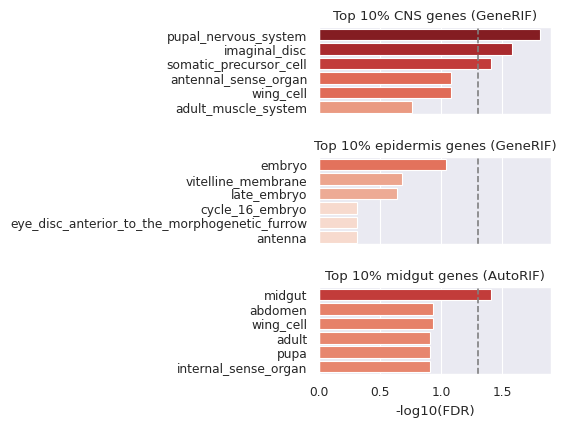

In [21]:
enrichment_files = [
    ('Top 10% CNS genes (GeneRIF)', '../plots/flysta/Anatomy_GeneRIF_CNS.txt'),
    ('Top 10% epidermis genes (GeneRIF)', '../plots/flysta/Anatomy_GeneRIF_epidermis.txt'),
    ('Top 10% midgut genes (AutoRIF)', '../plots/flysta/Anatomy_AutoRIF_midgut.txt')]

fig, axs = plt.subplots(len(enrichment_files), 1, sharex=True, figsize=(3, 1.5*len(enrichment_files)), gridspec_kw={'hspace': .5})
for ax, (title, fname) in zip(axs, enrichment_files):
    # Load data
    # https://maayanlab.cloud/FlyEnrichr/enrich
    anatomy_enrich = pd.read_csv(fname, delimiter='\t')
    anatomy_enrich['-log10(FDR)'] = -np.log10(anatomy_enrich['Adjusted P-value'])

    # Make panel
    display_col = '-log10(FDR)'
    num_terms = 6
    df_filt = anatomy_enrich.sort_values(display_col, ascending=False).iloc[:num_terms]
    palette = list(plt.cm.Reds(df_filt[display_col]/-np.log10(.01)))
    # print(df_filt)
    sns.barplot(df_filt, x=display_col, y='Term', hue='Term', palette=palette, legend=False, ax=ax)
    ax.axvline(x=-np.log10(.05), ls='--', color='gray')
    ax.set_xlim(left=0)
    ax.set(title=title, ylabel=None)

# Save
fig.savefig(f'../plots/flysta/perturbation_enrichment.pdf', transparent=True, bbox_inches='tight')
